# Project Analysis
## LEGO Secondary Market Investment Analysis

### Purpose of This Notebook

This notebook is used to implement the regression and classification analysis for the project.
The purpose of this analysis is to evaluate measurable characteristics of LEGO sets, such as price-per-piece, minifigure count, and age, to determine if a LEGO set is investment-worthy and if secondary prices can be predicted.

The models used are:

 - Regression Models:
    - Baseline regression
    - log-transformed regression
    - Random Forest regression

 - Classification Models:
    - Baseline classification
    - Random Forest classification



The first code cell will import the libraries needed for data manipulation, model development, and evaluation.
The sklearn libraries are used to implement the supervised regression model and compute the evaluation.
The first cell also reads the cleaned dataset and prints a few rows to verify that the read was processed correctly.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv("../data/processed/lego_model_ready.csv")
df.head()

,aftermarket_value_ratio,Current_Price,USD_MSRP,price_per_piece,Pieces,Minifigures,age_years,Theme_Group,Availability
0,3.881771,50.4242,12.99,1.623750,8.0,0,34,Modern day,Retail
1,1.231717,16.0000,12.99,1.623750,8.0,0,34,Modern day,Retail
2,1.000357,28.0000,27.99,4.665000,6.0,0,34,Modern day,Retail
3,1.428912,60.0000,41.99,13.996667,3.0,0,34,Modern day,Retail
4,0.466978,7.0000,14.99,14.990000,1.0,0,33,Pre-school,{Not specified}


## Regression Modeling

The next cell will define the target variable for this regression model, "aftermarket_value_ratio", which is calculated using the secondary market price and MSRP.
The ratio is used to normalize prices across sets and reflects investment performance.

This cell also selects the predictor variables based on the project hypothesis.
The retail price and current market price are excluded because they were used to calculate the target variable.

In [ ]:
y = df["aftermarket_value_ratio"]

X = df[
    [
        "price_per_piece",
        "Pieces",
        "Minifigures",
        "age_years",
    ]
]

The following cell is used to split the data into training and testing sets using an 80/20 ratio.
Splitting the data into two sets reduced overfitting and ensured the model is evaluated on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Baseline Regression Model

A linear regression model is used as the baseline analytical method.
This model provides a benchmark for assessing how well characteristics of a LEGO set will explain aftermarket performance.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


The following metrics are used to evaluate model performance:
- **R²** to measure explanatory power
- **Mean Absolute Error (MAE)** to measure average prediction error
- **Root Mean Squared Error (RMSE)** to penalize larger errors

These metrics will serve as a benchmark for evaluating more complex models later.

In [ ]:
y_pred = lin_reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5

r2, mae, rmse

print(f'R² is {r2}')
print(f'MAE is {mae}')
print(f'RMSE is {rmse}')

R² is 0.1732196246681188
MAE is 1.0487252525292234
RMSE is 2.11676021111718


The regression coefficients provide the direction and relative magnitude of each predictor's influence on aftermarket performance.  
This analysis helps evaluate practical significance and helps identify which LEGO set characteristics are most influential.

R² indicates that approximately 17% of a LEGO set's resale value is explained by the characteristics being measured: price per piece, piece count, minifigures, and age.

The mean absolute error (MAE) indicates that the models predicting the aftermarket_vale_ratio are off by about 1.05 units, which is a reasonably large miss. This means that if a LEGO set is actually worth twice its MSRP price, the model might predict it is worth one or three times its MSRP price.

Root mean squared error (RMSE) in this case is similar to MAE. A value of ~2.12 means that if a LEGO set sells for twice its MSRP price, it would be predicted as either worthless, being zero times MSRP, or it would be expected to sell for four times its MSRP. This is happening because RMSE struggles with outliers, and in this case, there are some extremely high-valued sets in the dataset.

The next cell utilizes the features and coefficients to create a new dataframe, determining which features have the most significant impact on a LEGO set's investment worthiness.
The features are sorted by the absolute value of their coefficient.

In [ ]:
coef_df = pd.DataFrame(
    {
        "feature": X.columns,
        "coefficient": lin_reg.coef_
    }
).sort_values(by="coefficient", key=abs, ascending=False)

coef_df

,feature,coefficient
3,age_years,0.245423
0,price_per_piece,-0.022595
2,Minifigures,-0.015497
1,Pieces,-0.000053


The output of the last cell indicates that the age of a LEGO set is the strongest indicator of its success in the aftermarket. At the same time, piece count and minifigure count have either no effect or an adverse effect on the resale price. The output also indicates that the price per piece is essential, as price efficiency matters.

---

### Log-Transformed Regression Model

Since the aftermarket value ratios are skewed by outliers, a log-transformed version of the target variable is used for evaluation.
This transformation will help improve model fit and capture nonlinear relationships between the predictors and the target.

In [ ]:
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

lin_reg_log = LinearRegression()
lin_reg_log.fit(X_train, y_train)

y_pred_log = lin_reg_log.predict(X_test)

r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = mean_squared_error(y_test, y_pred_log) ** 0.5



print(f'R² log is {r2_log}')
print(f'MAE log is {mae_log}')
print(f'RMSE log is {rmse_log}')

R² log is 0.36873478604926646
MAE log is 0.2686348985863485
RMSE log is 0.3566149075308063


These results indicate that the log transformation improved our model, suggesting that aftermarket prices are multiplicative rather than additive. The model explains approximately 37% of the variance affecting the aftermarket price. Both errors, MAE and RSME, improved sufficiently for the predictions to be more trustworthy. In this model, outliers do not dominate the model's performance.


---



### Random Forest Regression Model

I will now use a random forest model to capture nonlinear relationships and feature interactions. The results of the log-transformed model justify the need for a random forest, as the variance, although improved, is still insufficient to claim that the log-transformed model is robust.

The ensemble-based supervised learning method is well-suited for structured tabular data and provides feature importance measures for interpretability.

The first cell will import the Random Forest Regressor and define our target variable.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

y_log = np.log1p(df["aftermarket_value_ratio"])


The next cell will split our data 80/20 into training and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

Using a fixed random state for reproducibility, the random forest regression will train the model using multiple decision trees to capture nonlinear patterns.

In [ ]:
rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


The next cell will use the same metrics I used in previous models to evaluate the model performance.

In [ ]:
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5

r2_rf, mae_rf, rmse_rf

print(f'R² random forest is {r2_rf}')
print(f'MAE random forest is {mae_rf}')
print(f'RMSE random forest is {rmse_rf}')

R² random forest is 0.44822875653795746
MAE random forest is 0.2446227712821587
RMSE random forest is 0.3334057582835275


Overall, the random forest model performs better in all measured metrics than the other two models; however, its variance remains relatively low. These results suggest that the resale value of LEGO is not linear and that interaction effects and thresholds are significant. Thus, ensemble models are a suitable approach for this project.

The next cell will sort the features by importance according to the results of the Random Forest model.

In [ ]:
importances = rf.feature_importances_

importance_df = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": importances
    }
).sort_values(by="importance", ascending=False)

importance_df

,feature,importance
3,age_years,0.460645
0,price_per_piece,0.243646
1,Pieces,0.221433
2,Minifigures,0.074276


The random forest model confirms that age is the strongest factor influencing a Lego set's aftermarket performance, in line with the findings of the linear models. This model also indicates that sets that deliver more pieces per dollar perform better in secondary sales. The number of pieces performed better in this model as well, suggesting that piece count does not follow a linear pattern. Lastly, minifigure inclusion is the lowest performer in this model at about 7% meaning it does contribute to a set's performance, but it is not usually a primary driver.

The following cell creates a bar chart that illustrates the relative importance of each feature from the random forest model.

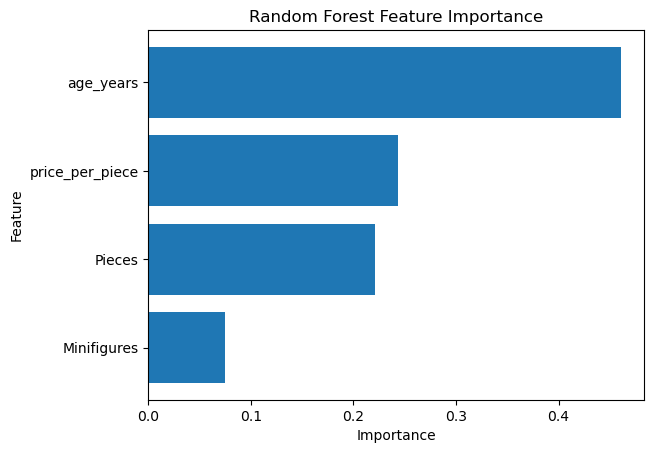

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.barh(importance_df["feature"], importance_df["importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()



The following cell creates a scatter plot that compares predicted versus actual log-transformed aftermarket value ratios to assess model fit and prediction accuracy.


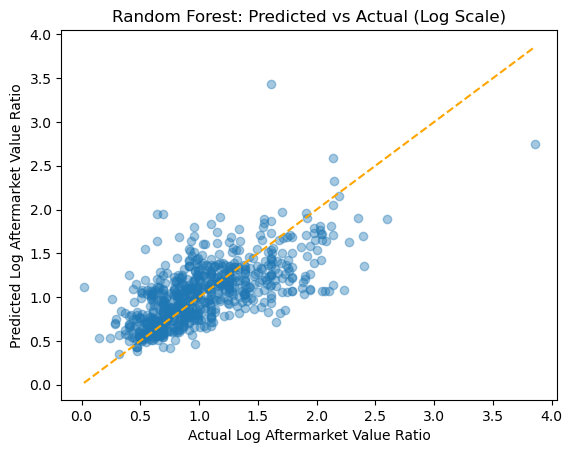

In [ ]:
plt.figure()
plt.scatter(y_test, y_pred_rf, alpha=0.4)
min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
plt.plot([min_val, max_val], [min_val, max_val], color="orange", linestyle="--")
plt.xlabel("Actual Log Aftermarket Value Ratio")
plt.ylabel("Predicted Log Aftermarket Value Ratio")
plt.title("Random Forest: Predicted vs Actual (Log Scale)")

plt.show()

The scatterplot above shows the strong positive relationship for the Random Forest model and captures general trends in LEGO aftermarket performance. The closer a dot is to the line that runs at a forty-five-degree angle in the middle, the better that set performed in the model.

The Random Forest regression model captures nonlinear relationships and interaction effects that linear models cannot address.  
Performance improvements and feature importance metrics demonstrate the value of ensemble-based modeling for evaluating LEGO investment potential.

---

## Classification Models
Next, I am adding a classification model to determine whether a LEGO set is investment-worthy or not investment-worthy.

### Baseline Classification Model

The first cell in this section will define a binary classification target to represent whether a LEGO set is investment-worthy. 

In [ ]:
df["is_investment_worthy"] = (df["aftermarket_value_ratio"] >= 2.0).astype(int)

df["is_investment_worthy"].value_counts(normalize=True)

is_investment_worthy
0    0.649376
1    0.350624
Name: proportion, dtype: float64

The output of the binary classification shows that about 65% of the LEGO sets from the dataset are not investment-worthy, and about 35% of the sets are worth investing in.
This output also serves as a baseline for the next model to compare to.

---

### Random Forest Classfication Model

The next cell will define features and the classification target. The same predictor variables are used as those in the regression model for consistency.

In [ ]:
X = df[
    [
        "price_per_piece",
        "Pieces",
        "Minifigures",
        "age_years",
    ]
]

y = df["is_investment_worthy"]

The next cell will split the data into training and test datasets using an 80/20 split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

The next cell imports the Random Forest Classifier and uses it to capture nonlinear patterns and interaction effects for binary investment classification.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_clf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


The next cell uses the classification metrics of accuracy, precision, recall, and F1-score to evaluate the model's ability to identify investment-worthy LEGO sets.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       468
           1       0.69      0.65      0.67       253

    accuracy                           0.77       721
   macro avg       0.75      0.75      0.75       721
weighted avg       0.77      0.77      0.77       721



**Precision**: This is the model's ability to correctly predict whether a LEGO set is investment-worthy. This model can predict correctly 69% of the time, nice.

**Recall** This indicates how often the model correctly identified an investment-worthy LEGO set. This model captures 65% of all truly investment-worthy sets.

**Accuracy** This is the proportion of all correct predictions out of all predictions made. This model has an accuracy of 77%.

**F1-Score** This is the harmonic mean of precision and recall, which balances both metrics. The F1-score for this model is 67%.

The next cell will import the seaborn package and create a confusion matrix to visualize correct and incorrect outcomes, providing insight into false positives and false negatives.

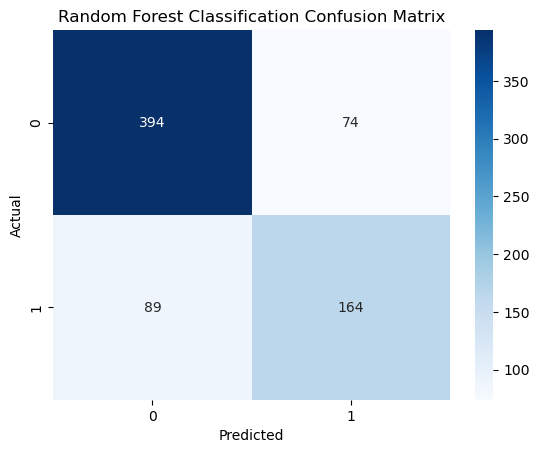

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Classification Confusion Matrix")
plt.show()


A confusion matrix is used to summarize the classification performance of a model. In this case, the model analyzes whether a LEGO set is investment-worthy, and it is considered investment-worthy if it has an aftermarket value ratio of at least 2.0.

The model correctly classified 394 LEGO sets as not investment worthy; these are known as true negatives. The model also classified 164 sets as investment-worthy, known as true positives.

There were 74 false positives, where the model predicted a set to be investment worthy when it was not.

The model identified 89 false negatives, representing investment-worthy sets that were not determined by the classifier.

The confusion matrix demonstrates a reliable identification of non-investment sets, while also successfully identifying a substantial portion of sets that perform well. This behavior helps support an investment decision, but should not be considered a reliable predictor of investment performance.


The last cell for this classification model sorts the features by importance. 

In [ ]:
clf_importance_df = pd.DataFrame(
    {
        "feature": X.columns,
        "importance": rf_clf.feature_importances_
    }
).sort_values(by="importance", ascending=False)

clf_importance_df

,feature,importance
3,age_years,0.425644
0,price_per_piece,0.256061
1,Pieces,0.236094
2,Minifigures,0.082201


The feature importance ranking for this model is very similar to the Random Forest Regression model. All features are ranked in the same order; however, the importance of price-per-piece, pieces, and minifigures has all improved.


The classification model demonstrates the feasibility of identifying investment-worthy LEGO sets using measurable set characteristics.  
Results support the use of supervised classification as a complementary decision-support tool alongside regression analysis.
